In [1]:
%matplotlib inline
import numpy as np
import sklearn.cluster
import sklearn.feature_extraction
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
# Generate a random data matrix. n = number of data points; m = length of each data point; num_types = number of types
def gen_data(n, m, num_types):
    # type for each data point (each from 0 to n-1)
    types = np.trunc(np.random.random_sample(n)*num_types)
    # list of random vectors of m integers between 20 and 40, to serve as the mean for each type
    means = [np.random.randint(20,40,m) for t in range(num_types)]
    # list of vectors of standard deviations for each type
    stddevs = 2 * np.ones([num_types,m])
    # generate a data matrix and round to the nearest thousandth
    return np.round(map(lambda t : list(np.random.randn(len(means[t])) * stddevs[t] + means[t]), map(int, types)),3)

In [6]:
# run k-means clustering on M, for each k values in k_vals
def k_mean_test(M, k_vals):
    results = []
    # sum of squared Euclidean distances from mean
    var = sum(np.var(M,0))*len(M)
    # loop through all k values provided
    for k in k_vals:
        # fit k-means clusterer
        fit = sklearn.cluster.KMeans(n_clusters=k).fit(M)
        # sum of squared Euclidean distance from cluster center
        within_var = sum(map(lambda r : min(r)**2, fit.transform(M)))
        results.append((fit, k, within_var/var))
    return results

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0000000000000007, 0.60831520295650698, 0.34585464424386914, 0.14743993837553054, 0.11585334343282153, 0.10660674330456738, 0.099577639159663278, 0.092789101060629223, 0.088881680146391556, 0.083475320504014627]]
Wall time: 513 ms


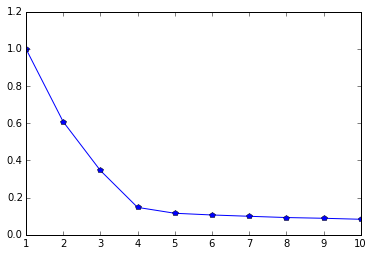

In [4]:
%%time
# generate 200 data points in R^4, with 5 topics
M = gen_data(200, 4, 5)
# plot results for k=1 to 10
plot_results = map(list, zip(*k_mean_test(M, range(1,11))))
print plot_results
plt.plot(plot_results[0], plot_results[1], 'p-')

In [5]:
%%time
M = np.loadtxt("mat.csv", delimiter = ",")

Wall time: 1min 18s


In [8]:
%%time
M_tfidf = sklearn.feature_extraction.text.TfidfTransformer().fit_transform(M).toarray()

Wall time: 775 ms


In [9]:
%%time
var = sum(np.var(M_tfidf,0))*len(M_tfidf)
fit = sklearn.cluster.KMeans(n_clusters=14).fit(M_tfidf)
within_var = sum(map(lambda r : min(r)**2, fit.transform(M_tfidf)))
#results.append((k, within_var/var))

#plot_results = map(list, zip(*k_mean_test(M, range(1,21))))
#print plot_results
#plt.plot(plot_results[0], plot_results[1], 'p-')

Wall time: 1min 6s


In [21]:
pred = fit.predict(M_tfidf)
print 'Number of documents per cluster:', [len(pred[pred==i]) for i in range(14)]
for cluster in range(14):
    print
    print 'Documents in category %s:' % cluster, [i for i,j in enumerate(pred) if j==cluster]

Number of documents per cluster: [64, 69, 204, 60, 54, 39, 64, 148, 105, 311, 69, 41, 280, 196]

Documents in category 0: [31, 36, 64, 70, 78, 102, 152, 193, 226, 227, 235, 256, 277, 278, 301, 340, 352, 361, 482, 486, 496, 519, 559, 595, 611, 624, 636, 692, 705, 708, 719, 743, 813, 840, 847, 924, 943, 959, 968, 1038, 1040, 1074, 1133, 1186, 1208, 1259, 1263, 1311, 1357, 1374, 1387, 1417, 1431, 1445, 1453, 1454, 1457, 1541, 1578, 1591, 1626, 1646, 1659, 1698]

Documents in category 1: [6, 7, 67, 75, 79, 109, 143, 177, 186, 190, 212, 238, 279, 314, 333, 412, 445, 452, 464, 476, 483, 520, 538, 579, 580, 613, 617, 625, 654, 698, 707, 722, 728, 895, 928, 939, 953, 1025, 1030, 1033, 1090, 1112, 1136, 1151, 1168, 1177, 1187, 1213, 1215, 1232, 1234, 1244, 1262, 1289, 1291, 1354, 1382, 1383, 1388, 1460, 1480, 1483, 1574, 1579, 1589, 1595, 1651, 1664, 1678]

Documents in category 2: [0, 1, 17, 34, 35, 86, 112, 117, 121, 123, 128, 130, 134, 145, 146, 153, 154, 155, 167, 178, 180, 204, 213, 223, 2